### GOAL

##### We aim to optimize inventory levels by analyzing sales trend and minimizing stockouts while reducing overstock situations. We aim to forecast the demand("Units sold"), so we can plan how much inventory to order. Once we have a demand forecast, we can then determine the optimal inventory to hold (to reduce both stockouts and overstock).<br>
##### After tons of research, we chose "Store ID" of S001 and "Region" of East for our analysis. Then we drop Store ID, Product ID, Category, Region, Weather Condition, Competitor Pricing , Seasonality, Keep Inventory Level, Price, Discount, Holiday Promotion, Weather Condition, Competitor Pricing, Seasonality. <br>

Our data includes 9 features(columns):<br>
**Date**: Daily records from [start_date] to [end_date] <br>
**Store ID & Product ID**: Unique indentifiers for stores and products.<br>
**Category**: Products categories like Electronics, Clothing, Groceries, etc<br>
**Region**:Geographic region of the store.<br>
**Inventory Level**: Stock available at the beginning of the day.<br> 
**Units Sold**: Unites sold during the day.<br>
**Demand Forecast**: Predicted demand based on past trends.<br>
**Weather Condition**: Daily weather impacting sales.<br>
**Holiday/Promotion**: Indicators for holidays or promotions.<br>

We intend to focus on ,I intend to use the method of "Time Series Forecasting" to first do a Exploratory Data Analysis to indentify patterns and use ARIMA to predict future stock trends.

### Part 1: Exploratory Data Analysis (EDA)

##### Import libraries & load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('retail_store_inventory.csv')
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Display first few rows and basic info
print("Dataset Preview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Preview:
        Date Store ID Product ID     Category Region  Inventory Level  \
0 2022-01-01     S001      P0001    Groceries  North              231   
1 2022-01-01     S001      P0002         Toys  South              204   
2 2022-01-01     S001      P0003         Toys   West              102   
3 2022-01-01     S001      P0004         Toys  North              469   
4 2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1

/var/folders/w_/dqfrqtnd0_3_m8wlgf8r1fkr0000gn/T/ipykernel_26428/1084290697.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [2]:
# Count unique values for 'Weather Condition'
weather_counts = df['Weather Condition'].value_counts()
print("Weather Condition Counts:")
print(weather_counts)

# Count unique values for 'Seasonality'
seasonality_counts = df['Seasonality'].value_counts()
print("\nSeasonality Counts:")
print(seasonality_counts)

Category_counts = df['Category'].value_counts()
print("\nSeasonality Counts:")
print(Category_counts)


Weather Condition Counts:
Weather Condition
Sunny     18290
Rainy     18278
Snowy     18272
Cloudy    18260
Name: count, dtype: int64

Seasonality Counts:
Seasonality
Spring    18317
Summer    18305
Winter    18285
Autumn    18193
Name: count, dtype: int64

Seasonality Counts:
Category
Furniture      14699
Toys           14643
Clothing       14626
Groceries      14611
Electronics    14521
Name: count, dtype: int64


Use one-hot encoding to convert categorical predictors

In [3]:
# Encode categorical columns first
filtered_df = pd.get_dummies(df, columns=['Weather Condition', 'Seasonality'], drop_first=True)

# Verify your column names exactly as generated by pandas
print(filtered_df.columns)


Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing',
       'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter'],
      dtype='object')


In [4]:
filtered_df[['Weather Condition_Rainy','Weather Condition_Snowy', 'Weather Condition_Sunny',
            'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']] = filtered_df[[
                'Weather Condition_Rainy','Weather Condition_Snowy', 'Weather Condition_Sunny',
                'Seasonality_Spring', 'Seasonality_Summer', 
                'Seasonality_Winter'
            ]].astype(int)

filtered_df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,0,29.69,1,0,0,0,0,0
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,0,66.16,0,0,1,0,0,0
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,1,31.32,0,0,1,0,1,0
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,1,34.74,0,0,0,0,0,0
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,0,68.95,0,0,1,0,1,0


In [5]:
#  Filter the data for the specified Store ID and Region
store_filter = (filtered_df["Store ID"] == "S001") & (filtered_df["Region"] == "East") & (filtered_df["Category"] == "Clothing")
filtered_df = filtered_df[store_filter]
filtered_df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
18,2022-01-01,S001,P0019,Clothing,East,352,257,186,267.38,73.28,10,0,77.26,0,0,0,0,0,1
107,2022-01-02,S001,P0008,Clothing,East,92,74,121,67.04,58.89,5,0,61.56,0,0,0,0,0,0
201,2022-01-03,S001,P0002,Clothing,East,282,199,70,193.26,54.02,0,0,52.91,0,0,0,1,0,0
211,2022-01-03,S001,P0012,Clothing,East,72,2,62,9.81,86.93,15,0,83.11,0,0,0,0,1,0
215,2022-01-03,S001,P0016,Clothing,East,148,31,160,35.11,93.61,15,1,94.15,0,1,0,1,0,0


In [6]:
# Columns you want to drop
columns_to_drop = [
    "Store ID",
    "Product ID",
    "Category",
    "Region"
]

filtered_df = filtered_df.drop(columns=columns_to_drop, errors='ignore')
filtered_df.head()

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
18,2022-01-01,352,257,186,267.38,73.28,10,0,77.26,0,0,0,0,0,1
107,2022-01-02,92,74,121,67.04,58.89,5,0,61.56,0,0,0,0,0,0
201,2022-01-03,282,199,70,193.26,54.02,0,0,52.91,0,0,0,1,0,0
211,2022-01-03,72,2,62,9.81,86.93,15,0,83.11,0,0,0,0,1,0
215,2022-01-03,148,31,160,35.11,93.61,15,1,94.15,0,1,0,1,0,0


In [7]:
# Aggregate explicitly by 'Date' column
filtered_df = filtered_df.groupby('Date').agg({
    'Inventory Level': 'mean',
    'Units Sold': 'sum',
    'Units Ordered': 'sum',
    'Demand Forecast': 'sum',
    'Price': 'mean',
    'Discount': 'mean',
    'Holiday/Promotion': 'mean',
    'Competitor Pricing': 'mean',
    'Weather Condition_Rainy': 'mean',
    'Weather Condition_Snowy': 'mean',
    'Weather Condition_Sunny': 'mean',
    'Seasonality_Spring': 'mean',
    'Seasonality_Summer': 'mean',
    'Seasonality_Winter': 'mean'
})  

filtered_df.head()


,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
Date,,,,,,,,,,,,,,
2022-01-01,352.000000,257,186,267.38,73.280000,10.0,0.000000,77.260000,0.0,0.000000,0.0,0.000000,0.000000,1.0
2022-01-02,92.000000,74,121,67.04,58.890000,5.0,0.000000,61.560000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2022-01-03,167.333333,232,292,238.18,78.186667,10.0,0.333333,76.723333,0.0,0.333333,0.0,0.666667,0.333333,0.0
2022-01-04,77.000000,7,76,22.66,98.280000,15.0,1.000000,95.380000,0.0,0.000000,0.0,1.000000,0.000000,0.0
2022-01-06,342.500000,526,307,524.67,31.030000,12.5,1.000000,31.330000,0.0,0.000000,0.0,0.000000,0.000000,0.5


In [8]:
filtered_df = filtered_df.resample('D').sum().fillna(0)
filtered_df.head()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
Date,,,,,,,,,,,,,,
2022-01-01,352.000000,257,186,267.38,73.280000,10.0,0.000000,77.260000,0.0,0.000000,0.0,0.000000,0.000000,1.0
2022-01-02,92.000000,74,121,67.04,58.890000,5.0,0.000000,61.560000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2022-01-03,167.333333,232,292,238.18,78.186667,10.0,0.333333,76.723333,0.0,0.333333,0.0,0.666667,0.333333,0.0
2022-01-04,77.000000,7,76,22.66,98.280000,15.0,1.000000,95.380000,0.0,0.000000,0.0,1.000000,0.000000,0.0
2022-01-05,0.000000,0,0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


Create column of 'Demand Error', that's something we want to predict further.

In [9]:
filtered_df['Demand Error'] = filtered_df['Units Sold'] - filtered_df['Demand Forecast']
columns_to_drop = [
    "Units Sold",
    "Demand Forecast"
]
filtered_df = filtered_df.drop(columns=columns_to_drop, errors='ignore')
filtered_df.head()

,Inventory Level,Units Ordered,Price,Discount,Holiday/Promotion,Competitor Pricing,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter,Demand Error
Date,,,,,,,,,,,,,
2022-01-01,352.000000,186,73.280000,10.0,0.000000,77.260000,0.0,0.000000,0.0,0.000000,0.000000,1.0,-10.38
2022-01-02,92.000000,121,58.890000,5.0,0.000000,61.560000,0.0,0.000000,0.0,0.000000,0.000000,0.0,6.96
2022-01-03,167.333333,292,78.186667,10.0,0.333333,76.723333,0.0,0.333333,0.0,0.666667,0.333333,0.0,-6.18
2022-01-04,77.000000,76,98.280000,15.0,1.000000,95.380000,0.0,0.000000,0.0,1.000000,0.000000,0.0,-15.66
2022-01-05,0.000000,0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00


##### 2. Split into Training & Test Sets

In [10]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import itertools

train_size = int(len(filtered_df) * 0.8)

train_df = filtered_df.iloc[:train_size]
test_df = filtered_df.iloc[train_size:]

# Target variable
y_train = train_df['Demand Error']
y_test = test_df['Demand Error']

# Addding noise to the training dataset Clearly define noise level
noise_std = 0.01 * np.std(y_train)  

# Add Gaussian noise explicitly
y_train_noisy = y_train + np.random.normal(0, noise_std, size=y_train.shape)

# Exogenous variables
exog_cols = ['Inventory Level', 
              'Price', 'Discount', 'Holiday/Promotion',
              'Competitor Pricing', 'Weather Condition_Rainy',
              'Weather Condition_Snowy', 'Weather Condition_Sunny',
              'Seasonality_Spring', 'Seasonality_Summer','Seasonality_Winter']

train_exog = train_df[exog_cols]
test_exog = test_df[exog_cols]


##### 3. Grid-Search Over non-seasonal (p,d,q) and seasonal (P, D, Q, m)

The seasonal components are defined as follows:
P: Seasonal Autoregressive order.
D: Seasonal Differencing order.
Q: Seasonal Moving Average order.
m: Seasonality period (7 for weekly seasonality, 12 for monthly, etc.).
Typically, for daily data with weekly cycles, set m=7.

In [11]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Define non-seasonal parameters (excluding (0,0,0))
p = d = q = range(0, 3)
pdq = [x for x in itertools.product(p, d, q) if x != (0,0,0)]

# Define seasonal parameters
P = D = Q = range(0, 2)  # usually small (0 or 1)
m = 7  # Weekly seasonality (change if needed)

seasonal_pdq = list(itertools.product(P, D, Q, [m]))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Start full grid search
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(y_train,
                            exog=train_exog,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit(disp=False, maxiter=200, method = 'nm')

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            print(f"Skipping order {order} and seasonal order {seasonal_order}: {e}")
            continue

print(f"Best SARIMAX order: {best_order}")
print(f"Best seasonal_order: {best_seasonal_order}")
print(f"Best AIC: {best_aic}")



Best SARIMAX order: (0, 0, 2)
Best seasonal_order: (0, 1, 1, 7)
Best AIC: 4207.77167658211


##### 4. Fit SARIMAX with Best Parameters & Predict

In [12]:
# Fit model with best parameters
model = SARIMAX(y_train_noisy, exog=train_exog,
                order=best_order,
                seasonal_order= best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False) # Maybe add some noise into the fitting process to make 

results = model.fit(disp=False)
print(results.summary())

# Predictions
y_pred = results.predict(start=test_exog.index[0], end=test_exog.index[-1], exog=test_exog)



                                      SARIMAX Results                                      
Dep. Variable:                        Demand Error   No. Observations:                  584
Model:             SARIMAX(0, 0, 2)x(0, 1, [1], 7)   Log Likelihood               -2086.296
Date:                             Wed, 12 Mar 2025   AIC                           4202.593
Time:                                     20:33:08   BIC                           4267.698
Sample:                                 01-01-2022   HQIC                          4228.001
                                      - 08-07-2023                                         
Covariance Type:                               opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Inventory Level            -0.0047      0.004     -1.315      0.188      -0.012 

##### 5. Forecast & Evaluate

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')
print(f'MAE: {mae}')

RMSE: 9.214273841001196
R-squared: 0.07711339974198639
MAE: 6.440114053922162


#### Visualization (Actual vs. Predicted Demand Error)

In [14]:
# Create a DataFrame to hold the predictions and actual values
comparison_df = pd.DataFrame({
    'Actual Demand Error': y_test,
    'Predicted Demand Error': forecast
}, index=y_test.index)

print(comparison_df['Predicted Demand Error'].mean())


NameError: name 'forecast' is not defined

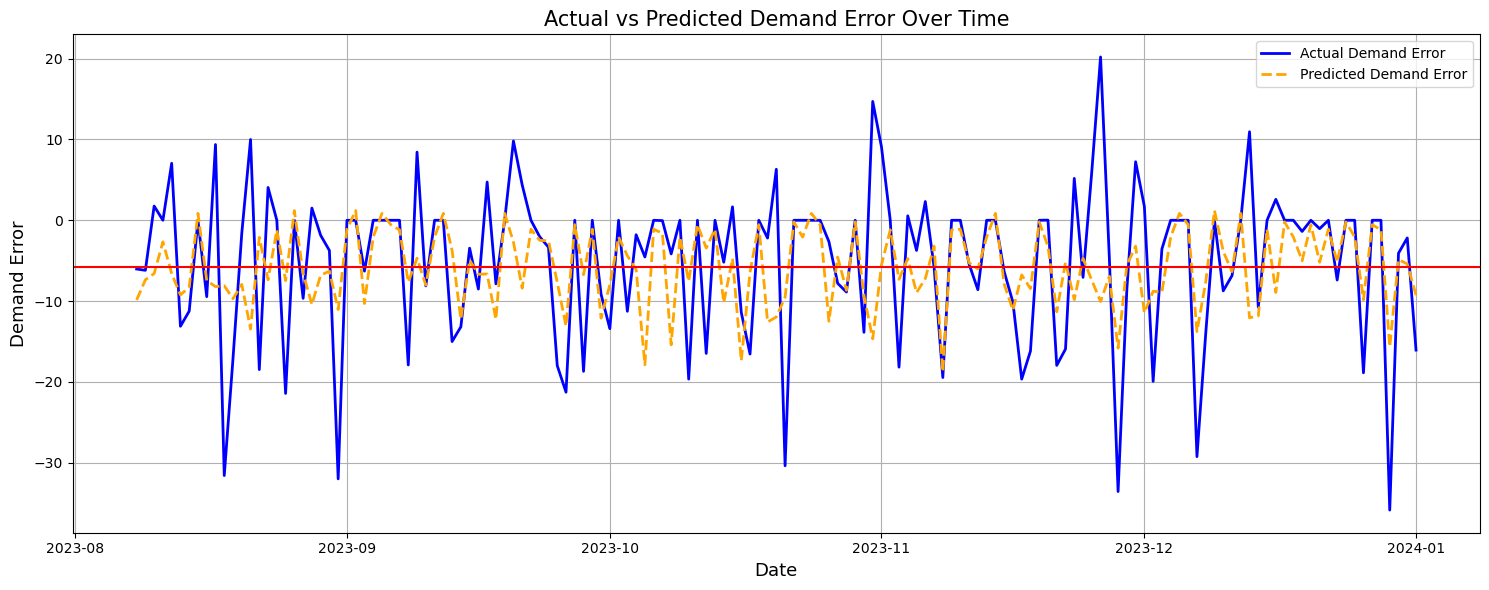

In [ ]:
import matplotlib.pyplot as plt
# clearly defined forecast values
forecast = results.forecast(steps=len(y_test), exog=test_exog)

# Create a DataFrame to hold the predictions and actual values
comparison_df = pd.DataFrame({
    'Actual Demand Error': y_test,
    'Predicted Demand Error': forecast
}, index=y_test.index)

# Plotting clearly over time
plt.figure(figsize=(15, 6))

# Actual demand error (blue solid line)
plt.plot(comparison_df.index, comparison_df['Actual Demand Error'],
         label='Actual Demand Error', color='blue', linewidth=2)

# Predicted demand error (orange dashed line)
plt.plot(comparison_df.index, comparison_df['Predicted Demand Error'],
         label='Predicted Demand Error',
         color='orange', linewidth=2, linestyle='--')
plt.axhline(y = -5.781712173857287, color = 'r')
# Formatting clearly
plt.xlabel('Date', fontsize=13)
plt.ylabel('Demand Error', fontsize=13)
plt.title('Actual vs Predicted Demand Error Over Time', fontsize=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Based on that finding, I plan to refine my model. If I only keep the statistically significant predictors which is (Units Ordered, Weather Condition_Rainy), and Incorporate Lagged Variables, Use nixtla gradient-boost decision tree to do time series analysis instead of the SARIMAX. 
Since the SARIMAX model has embedded bias of predicting,   
ADD buffer to prediction model.   
Impact coding instead of One-hot encoding. 